# Phase 1 – ML-based IDS on Train_Test_IoT_Modbus

This notebook implements **Phase 1** of the experimental design described in the paper *“Cyber Threats in IIoT: Can ML Mitigate Vulnerabilities and Prevent Harm?”*. The goal of this phase is to use the official `Train_Test_IoT_Modbus` subset of the ToN_IoT dataset as a relatively balanced and manageable environment to design and tune three classical ML models:

- **Decision Trees (DT)**
- **Random Forests (RF)**
- **Support Vector Machines (SVM)**

The focus is strictly on **IIoT sensor telemetry** from a Modbus-based service. Each record contains four Modbus function-code counters (`FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`, `FC3_Read_Holding_Register`, `FC4_Read_Coil`) and two labels:

- `label`: binary flag (`0 = normal`, `1 = attack`)
- `type`: traffic / attack category (`normal`, `injection`, `backdoor`, `password`, `scanning`, `xss`)

Within this phase, the notebook addresses two related learning tasks:

1. **Binary intrusion detection** – distinguish *normal* vs *malicious* records using `label`.
2. **Multiclass intrusion classification** – discriminate between *normal* traffic and the five Modbus attack categories using `type`.

The work in this notebook is organised as follows:

1. **Data loading and initial exploration** of the `Train_Test_IoT_Modbus.csv` file (shape, feature types, class distributions).
2. **Data preparation and Train/validation/test splitting**: definition of feature matrices and target vectors for both the binary and multiclass tasks. Stratification on the multiclass labels, in order to preserve the attack-type distribution across all splits.
3. **Feature preprocessing**: standardisation of the four Modbus counters, with the scaler fitted only on the training split to avoid information leakage.
4. **Model training and hyperparameter tuning and Model selection** for DT, RF, and SVM using the validation set. Then, based on macro-averaged F1-score and inspection of false negative rates per attack category I am going to select the best models.
5. **Final evaluation** of the best configuration on the held-out test set.

In **Phase 2**, implemented in a separate notebook, the best-performing configurations obtained here will be re-evaluated on the full `IoT_Modbus` processed dataset, which preserves the original, highly imbalanced distribution of normal and attack records. This two-phase structure is intended to show how models that perform well on a “laboratory” subset behave when faced with a more realistic IIoT scenario.

**Note:** For all `.ipynb` files, I used LLM assistance. I asked it to explain each step of the process, provide markdown commentary, and offer limited guidance whenever I lost track of the workflow.

##1. Data loading and initial exploration

In this first step, I load the `Train_Test_IoT_Modbus.csv` file and perform a basic exploratory analysis.  
The goal is to confirm the shape of the dataset, inspect the data types of each column, and understand the overall class distribution before defining the ML tasks.


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.base import clone

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Load the Train_Test_IoT_Modbus subset
df = pd.read_csv(r"F:\GEPID\3Semestre\Cybersicurezza\TON DataSet\Train_Test_IoT_dataset\Train_Test_IoT_dataset\Train_Test_IoT_Modbus.csv")

# Quick check
print("Shape:", df.shape)
df.head()


Shape: (31106, 8)


,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
1,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
2,25-Apr-19,09:14:01,49389,52921,25770,13625,1,injection
3,25-Apr-19,09:14:02,49389,52921,25770,13625,1,injection
4,25-Apr-19,09:14:04,40665,44748,21098,35371,1,injection


The `Train_Test_IoT_Modbus.csv` file loads correctly into a Pandas dataframe with the following shape:

- **31,106 rows** (individual observations)
- **8 columns**:

  - `date`, `time`: timestamp of each record.
  - `FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`, `FC3_Read_Holding_Register`, `FC4_Read_Coil`: integer Modbus counters.
  - `label`: binary indicator of normal vs. attack traffic.
  - `type`: traffic / attack category.

The first rows confirm that all four Modbus features are present for each record, together with both labels (`label` and `type`).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31106 entries, 0 to 31105
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       31106 non-null  object
 1   time                       31106 non-null  object
 2   FC1_Read_Input_Register    31106 non-null  int64 
 3   FC2_Read_Discrete_Value    31106 non-null  int64 
 4   FC3_Read_Holding_Register  31106 non-null  int64 
 5   FC4_Read_Coil              31106 non-null  int64 
 6   label                      31106 non-null  int64 
 7   type                       31106 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.9+ MB


The `info()` summary shows that:

- All **31,106 entries are non-null** in every column, so there are no missing values to handle.
- The four Modbus features and the `label` column are stored as **64-bit integers**.
- `date`, `time` and `type` are stored as Python `object` (string) types.

For the purposes of this phase, the focus is on the four Modbus counters as numerical features, while `date` and `time` are treated as metadata and are not used as predictive variables. The `type` column will later be encoded as categorical labels for the multiclass classification task.


In [4]:
df[["FC1_Read_Input_Register",
    "FC2_Read_Discrete_Value",
    "FC3_Read_Holding_Register",
    "FC4_Read_Coil",
    "label"]].describe()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
count,31106.000000,31106.000000,31106.000000,31106.000000,31106.000000
mean,32833.925834,32781.719733,32582.861859,32805.957468,0.517778
std,18827.079410,18969.443025,18858.863346,18796.567682,0.499692
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16764.000000,16658.500000,16419.250000,16509.000000,0.000000
50%,32310.000000,32692.000000,32155.000000,32776.000000,1.000000
75%,49088.000000,49235.000000,48881.000000,49011.000000,1.000000
max,65510.000000,65535.000000,65523.000000,65534.000000,1.000000


The descriptive statistics of the four Modbus counters and the binary label are as follows:

- Each feature has **31,106 valid values**, matching the total number of records.
- The four Modbus counters have means around **32,000–33,000**  
  (`FC1 ≈ 32,834`, `FC2 ≈ 32,782`, `FC3 ≈ 32,583`, `FC4 ≈ 32,806`) and standard deviations in the range of **18,800–19,000**, indicating substantial variability in Modbus activity.
- All counters take values between **0** and roughly **65,500**, with the 25th percentile around **16,400–16,800** and the 75th percentile around **48,800–49,200**. This suggests that low and high Modbus-traffic regimes coexist in the dataset.
- The `label` column has a mean of approximately **0.518** and a standard deviation of **0.50**, which is consistent with a slightly higher proportion of attack records than normal records (close to a 52% vs. 48% split). The 25th percentile is `0` and the 75th percentile is `1`, confirming the expected binary structure.

Overall, these statistics confirm that the Modbus features are well-formed numeric variables with wide dynamic ranges, and that the dataset is only mildly imbalanced at the binary level, even though the attack proportion is higher than what would be expected in a typical real-world IIoT deployment.


In [5]:
print("Label distribution (0 = normal, 1 = attack):")
print(df["label"].value_counts())

print("\nAttack type distribution:")
print(df["type"].value_counts())


Label distribution (0 = normal, 1 = attack):
label
1    16106
0    15000
Name: count, dtype: int64

Attack type distribution:
type
normal       15000
injection     5000
backdoor      5000
password      5000
xss            577
scanning       529
Name: count, dtype: int64


The label distribution is as follows:

- `label = 0` (normal): **15,000** records  
- `label = 1` (attack): **16,106** records  

This means that the dataset is only slightly skewed towards attack traffic (about 48% normal vs. 52% attack), which is convenient for model training and comparison but clearly more attack-heavy than a realistic IIoT deployment.

The `type` column refines the picture:

- `normal`: 15,000 samples  
- `injection`: 5,000  
- `backdoor`: 5,000  
- `password`: 5,000  
- `xss`: 577  
- `scanning`: 529  

Most attack types (`injection`, `backdoor`, `password`) are **artificially balanced** at 5,000 samples each, while `xss` and `scanning` appear as **minority attack classes** with fewer than 600 instances.  

This structure confirms that `Train_Test_IoT_Modbus` is a curated, almost balanced benchmark: it is ideal for comparing ML models under controlled conditions, but it does **not** reflect the true rarity of attacks in production IIoT systems. This limitation will be explicitly addressed in Phase 2, when evaluating the same models on the full, highly imbalanced `IoT_Modbus` dataset.

## Extra step for curiousity
###Modbus function-code counters

In this step I perform a first exploratory analysis of the four Modbus function-code counters available in the `Train_Test_IoT_Modbus` subset:

- `FC1_Read_Input_Register`
- `FC2_Read_Discrete_Value`
- `FC3_Read_Holding_Register`
- `FC4_Read_Coil`

The goal is to understand their basic behaviour in the dataset and to check whether they carry any obvious discriminative signal with respect to the binary label (`normal` vs. `attack`). To this end, I present a summary of statistics and the correlation matrix between the four counters.


In [25]:
features = ["FC1_Read_Input_Register",
            "FC2_Read_Discrete_Value",
            "FC3_Read_Holding_Register",
            "FC4_Read_Coil"]

df.groupby("label")[features].agg(["mean", "std", "median"])


FC1_Read_Input_Register                        FC2_Read_Discrete_Value  \
                         mean           std   median                    mean   
label                                                                          
0                33026.042133  18749.375297  32470.0            33131.288867   
1                32655.002173  18897.985689  32220.0            32456.155532   

                             FC3_Read_Holding_Register                         \
                std   median                      mean           std   median   
label                                                                           
0      19057.529776  32993.0              32763.955733  18775.161223  32605.0   
1      18881.807730  32429.5              32414.203713  18935.509987  31913.0   

      FC4_Read_Coil                         
               mean           std   median  
label                                       
0      32806.436867  18855.614750  32429.0  
1      32805.510990  18741.993582  33043.0

In [26]:
df[features].corr()


,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil
FC1_Read_Input_Register,1.000000,-0.019215,0.003716,0.000400
FC2_Read_Discrete_Value,-0.019215,1.000000,-0.002387,0.001262
FC3_Read_Holding_Register,0.003716,-0.002387,1.000000,0.008806
FC4_Read_Coil,0.000400,0.001262,0.008806,1.000000


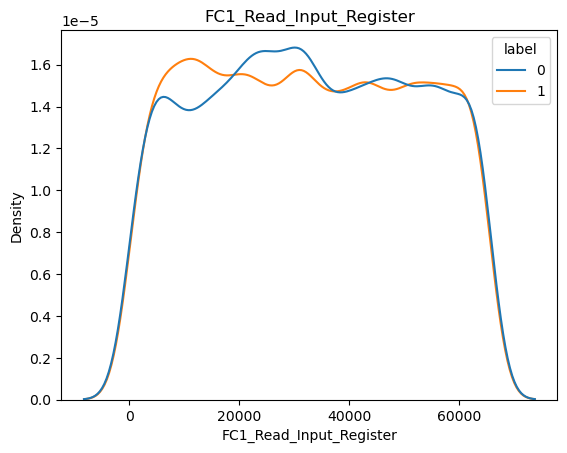

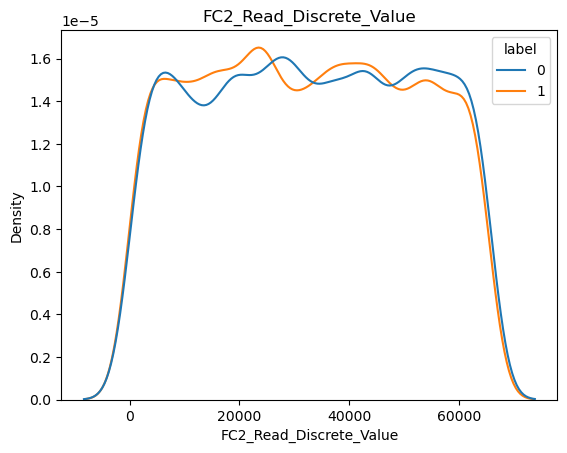

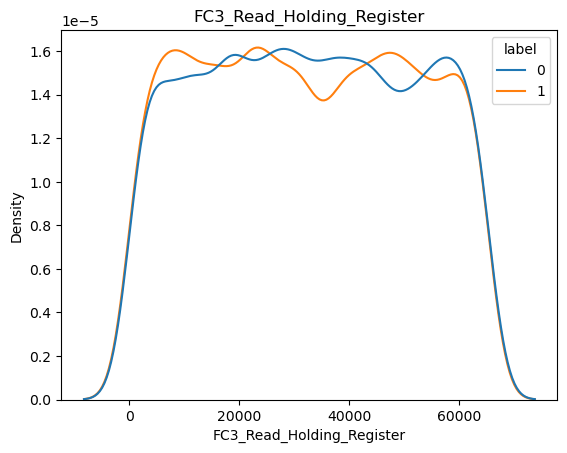

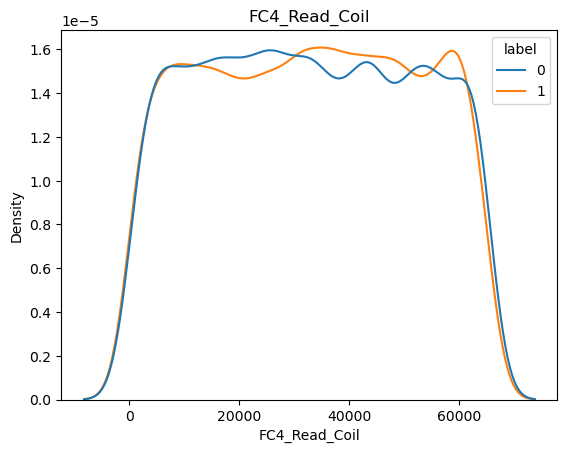

In [27]:
for col in features:
    sns.kdeplot(data=df, x=col, hue="label", common_norm=False)
    plt.title(col)
    plt.show()

#### Results and implications of the exploratory analysis

The class-conditional summary statistics show that the four Modbus counters behave very similarly for normal and attack records there is a lot of overlapping. For each feature, the mean, standard deviation and median are almost identical across `label = 0` (normal) and `label = 1` (attack). The models could struggle to separate them.

I need to reduce the decision threshhold because the differences are difficult to note.


## 2. Data preparation and Train/validation/test splitting

In this step, I formalise the two prediction tasks considered in Phase 1:

1. **Binary intrusion detection**

   - **Input features:** the four Modbus counters  
     (`FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`,  
     `FC3_Read_Holding_Register`, `FC4_Read_Coil`)
   - **Target variable:** `label`  
     (`0 = normal`, `1 = attack`)

2. **Multiclass intrusion classification**

   - **Input features:** the same four Modbus counters  
   - **Target variable:** `type`, which distinguishes between normal traffic and
     the five Modbus attack categories (`injection`, `backdoor`, `password`,
     `scanning`, `xss`).

The `date` and `time` columns are treated as metadata, I believe they could add noise to the prediction. 
For both tasks, I create a three-way split of the dataset into training, validation, and test sets with a 60% / 20% / 20% ratio. The split is **stratified on the multiclass labels** (`type`) so that all traffic and attack categories are represented in each subset with approximately the same proportions. This ensures that the validation and test metrics are meaningful for all classes, including the minority attacks (`scanning` and `xss`).


In [9]:
# 2.1 Define feature matrix (X): the four Modbus counters
feature_cols = [
    "FC1_Read_Input_Register",
    "FC2_Read_Discrete_Value",
    "FC3_Read_Holding_Register",
    "FC4_Read_Coil",
]

X = df[feature_cols].copy()   # DataFrame, conserva nombres

In [10]:
# 2.2 Define target vectors: binary label and multi-class attack type

# Binary target: normal (0) vs attack (1)
y_binary = df["label"].astype(int).to_numpy()

type_encoder = LabelEncoder()
y_multiclass = type_encoder.fit_transform(df["type"])

# Keep class names for later reporting/plots
class_names = type_encoder.classes_
class_names

print("Multiclass classes:", class_names)

Multiclass classes: ['backdoor' 'injection' 'normal' 'password' 'scanning' 'xss']


In [11]:
# 2.3 Helper to summarise class distributions
def summarize_distribution(name, y_encoded):
    """
    Print the class distribution for a given split.
    y_encoded is the integer-encoded multi-class label.
    """
    counts = pd.Series(y_encoded).value_counts().sort_index()
    print(f"\n{name} class distribution (index = encoded label):")
    for idx, count in counts.items():
        print(f"  {idx} ({class_names[idx]}): {count}")

# Distribution on the full dataset (sanity check)
summarize_distribution("Full dataset", y_multiclass)


Full dataset class distribution (index = encoded label):
  0 (backdoor): 5000
  1 (injection): 5000
  2 (normal): 15000
  3 (password): 5000
  4 (scanning): 529
  5 (xss): 577


In [12]:
# 2.4 Train / Validation / Test split 60 / 20 / 20

# First: split off 20% as final test set
X_temp, X_test, y_binary_temp, y_binary_test, y_multi_temp, y_multi_test = train_test_split(
    X,
    y_binary,
    y_multiclass,
    test_size=0.2,
    stratify=y_multiclass,   # stratify by multi-class labels
    random_state=42,
)

# Second: from remaining 80%, take 25% as validation (0.25 * 0.8 = 0.2 total)
X_train, X_val, y_binary_train, y_binary_val, y_multi_train, y_multi_val = train_test_split(
    X_temp,
    y_binary_temp,
    y_multi_temp,
    test_size=0.25,
    stratify=y_multi_temp,   # keep stratification
    random_state=42,
)

print("\nShapes:")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)

# Check class distributions in each split
summarize_distribution("Train split", y_multi_train)
summarize_distribution("Validation split", y_multi_val)
summarize_distribution("Test split", y_multi_test)


Shapes:
  X_train: (18663, 4)
  X_val  : (6221, 4)
  X_test : (6222, 4)

Train split class distribution (index = encoded label):
  0 (backdoor): 3000
  1 (injection): 3000
  2 (normal): 9000
  3 (password): 3000
  4 (scanning): 317
  5 (xss): 346

Validation split class distribution (index = encoded label):
  0 (backdoor): 1000
  1 (injection): 1000
  2 (normal): 3000
  3 (password): 1000
  4 (scanning): 106
  5 (xss): 115

Test split class distribution (index = encoded label):
  0 (backdoor): 1000
  1 (injection): 1000
  2 (normal): 3000
  3 (password): 1000
  4 (scanning): 106
  5 (xss): 116


In [13]:
# 2.5 Cross-validation splitter for later model tuning

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

print("\nStratifiedKFold configured with 5 folds on the training set.")


StratifiedKFold configured with 5 folds on the training set.


Because the scanning and xss classes have far fewer samples than the other traffic types, I use stratified k-fold cross-validation so that each fold preserves the original class proportions, making model comparisons fair and stable.

### Train–validation–test partition (60 / 20 / 20)

I have:

- **60% training set** (`X_train`), used to fit the models and to run stratified 5-fold cross-validation for hyperparameter tuning.
- **20% validation set** (`X_val`), used to inspect confusion patterns and performance per attack category.
- **20% test set** (`X_test`), held out from the beginning and used only once for the final assessment of generalisation performance.

For model selection, hyperparameter tuning is restricted to `X_train` using **stratified 5-fold cross-validation**. The validation set `X_val` is then used to compare the tuned models and to calibrate decision thresholds if needed, while the test set `X_test` remains untouched until the very end of the analysis, providing an unbiased estimate of generalisation performance.

## 3. Feature preprocessing: standardising the Modbus counters

Tree-based models such as Decision Trees and Random Forests are relatively insensitive to feature scaling (as far as I investigated with ChatGPT), but Support Vector Machines with an RBF kernel are not: they rely on distances in feature space, and unscaled features can distort these distances. Scaling seems to be the right move.

- The scaler is **fitted on the training set only**,  
- and then **applied to the validation and test sets**,  
  in order to avoid information leakage from future data into the training process (Recommended by my LLM).

The target vectors (`y_binary` and `y_multiclass`) are left unchanged.

In [14]:
# 3.1 Instantiate the scaler
scaler = StandardScaler()

# 3.2 Fit on training data only, then transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_val_scaled  :", X_val_scaled.shape)
print("  X_test_scaled :", X_test_scaled.shape)

Scaled shapes:
  X_train_scaled: (18663, 4)
  X_val_scaled  : (6221, 4)
  X_test_scaled : (6222, 4)


In [15]:
print("\nTraining means after scaling (should be ~0):")
print(np.mean(X_train_scaled, axis=0))

print("\nTraining stds after scaling (should be ~1):")
print(np.std(X_train_scaled, axis=0))


Training means after scaling (should be ~0):
[ 1.10790300e-16 -3.73108225e-17 -2.89349236e-17 -1.92645676e-16]

Training stds after scaling (should be ~1):
[1. 1. 1. 1.]


### 4. Model training and hyperparameter tuning and Model selection

In this step I train and tune three classical ML models that are widely used for tabular intrusion detection problems:

- **Decision Trees (DT)**
- **Random Forests (RF)**
- **Support Vector Machines (SVM)**

Each model is evaluated on two prediction tasks:

1. **Binary intrusion detection** (`label`: normal vs. attack)
2. **Multiclass intrusion classification** (`type`: normal + five attack categories)

In [16]:
# 4.1 Aliases for scaled features

Xtr = X_train_scaled
Xva = X_val_scaled

# Binary class names (for reports)
class_names_binary = np.array(["normal", "attack"])
labels_binary = np.array([0, 1])

# Multiclass labels (already encoded 0..K-1)
labels_multi = np.arange(len(class_names))   # class_names comes from LabelEncoder

# 5-fold stratified CV on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [17]:
# 4.2 Helper functions
# -------------------------------

def tune_model(
    estimator,
    param_grid,
    X_train,
    y_train,
    cv,
    model_name,
    task_name,
    scoring="f1_macro",
):
    """
    Run GridSearchCV with the chosen scoring metric and return the best estimator.
    """
    print(f"\n===== Tuning {model_name} ({task_name}) =====")
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV {scoring}: {grid.best_score_:.4f}")
    return grid.best_estimator_


def evaluate_on_validation(
    model,
    X_val,
    y_val,
    class_names,
    labels,
    model_name,
    task_name,
):
    """
    Evaluate a trained model on the validation set and print detailed metrics,
    including macro-F1, weighted-F1, and per-class FNR/FPR.
    """
    print(f"\n----- Validation performance for {model_name} ({task_name}) -----")
    y_pred = model.predict(X_val)

    # Classification report (forces consistent label order)
    print(
        classification_report(
            y_val,
            y_pred,
            labels=labels,
            target_names=class_names,
            digits=4,
            zero_division=0,
        )
    )

    # Confusion matrix with the same label order
    cm = confusion_matrix(y_val, y_pred, labels=labels)

    # Macro and weighted F1
    macro_f1 = f1_score(y_val, y_pred, average="macro")
    weighted_f1 = f1_score(y_val, y_pred, average="weighted")

    print(f"Macro-F1:    {macro_f1:.4f}")
    print(f"Weighted-F1: {weighted_f1:.4f}")

    # False Negative Rate (FNR) per class
    fnr_per_class = {}
    fpr_per_class = {}

    for idx, cls in enumerate(class_names):
        tp = cm[idx, idx]
        fn = cm[idx, :].sum() - tp
        fp = cm[:, idx].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        fnr_per_class[cls] = fnr
        fpr_per_class[cls] = fpr

    print("\nFalse Negative Rate (missed attacks) per class:")
    for cls, fnr in fnr_per_class.items():
        print(f"  {cls}: {fnr:.4f}")

    print("\nFalse Positive Rate (false alarms) per class:")
    for cls, fpr in fpr_per_class.items():
        print(f"  {cls}: {fpr:.4f}")

    return {
        "cm": cm,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "fnr": fnr_per_class,
        "fpr": fpr_per_class,
    }

In [34]:
# 4.3 Hyperparameter grids

dt_param_grid = {
    "max_depth": [None, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

rf_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2],
}

svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.001],
    "class_weight": [None, "balanced"],
    "kernel": ["rbf", "linear"],
}

In [19]:
# 4.4 Binary classification: normal vs attack

# Decision Tree (binary)
dt_bin = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="binary",
    scoring="f1",  # focus on label: 1 = attack
)

res_dt_bin = evaluate_on_validation(
    model=dt_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Decision Tree",
    task_name="binary",
)


===== Tuning Decision Tree (binary) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1}
Best CV f1: 0.9085

----- Validation performance for Decision Tree (binary) -----
              precision    recall  f1-score   support

      normal     0.9279    0.9563    0.9419      3000
      attack     0.9581    0.9308    0.9443      3221

    accuracy                         0.9431      6221
   macro avg     0.9430    0.9436    0.9431      6221
weighted avg     0.9435    0.9431    0.9431      6221

Macro-F1:    0.9431
Weighted-F1: 0.9431

False Negative Rate (missed attacks) per class:
  normal: 0.0437
  attack: 0.0692

False Positive Rate (false alarms) per class:
  normal: 0.0692
  attack: 0.0437


In [20]:
# Random Forest (binary)
rf_bin = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Random Forest",
    task_name="binary",
    scoring="f1",
)

res_rf_bin = evaluate_on_validation(
    model=rf_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Random Forest",
    task_name="binary",
)


===== Tuning Random Forest (binary) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV f1: 0.9150

----- Validation performance for Random Forest (binary) -----
              precision    recall  f1-score   support

      normal     0.9374    0.9533    0.9453      3000
      attack     0.9558    0.9407    0.9482      3221

    accuracy                         0.9468      6221
   macro avg     0.9466    0.9470    0.9468      6221
weighted avg     0.9469    0.9468    0.9468      6221

Macro-F1:    0.9468
Weighted-F1: 0.9468

False Negative Rate (missed attacks) per class:
  normal: 0.0467
  attack: 0.0593

False Positive Rate (false alarms) per class:
  normal: 0.0593
  attack: 0.0467


In [ ]:
# SVM (binary)
svm_bin = tune_model(
    estimator=SVC(),
    param_grid=svm_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="SVM",
    task_name="binary",
    scoring="f1_macro",
)

res_svm_bin = evaluate_on_validation(
    model=svm_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="SVM",
    task_name="binary",
)


===== Tuning SVM RBF (binary) =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best CV f1_macro: 0.5534

----- Validation performance for SVM RBF (binary) -----
              precision    recall  f1-score   support

      normal     0.5361    0.5173    0.5265      3000
      attack     0.5646    0.5830    0.5737      3221

    accuracy                         0.5514      6221
   macro avg     0.5504    0.5502    0.5501      6221
weighted avg     0.5509    0.5514    0.5510      6221

Macro-F1:    0.5501
Weighted-F1: 0.5510

False Negative Rate (missed attacks) per class:
  normal: 0.4827
  attack: 0.4170

False Positive Rate (false alarms) per class:
  normal: 0.4170
  attack: 0.4827


In [22]:
# 4.5 Multiclass classification: traffic type

# Decision Tree (multiclass)
dt_multi = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="multiclass",
    scoring="f1_macro",
)

res_dt_multi = evaluate_on_validation(
    model=dt_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="Decision Tree",
    task_name="multiclass",
)


===== Tuning Decision Tree (multiclass) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1}
Best CV f1_macro: 0.7686

----- Validation performance for Decision Tree (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9198    0.8830    0.9010      1000
   injection     0.9009    0.9360    0.9181      1000
      normal     0.9306    0.9610    0.9456      3000
    password     0.8967    0.8590    0.8774      1000
    scanning     0.8056    0.5472    0.6517       106
         xss     0.7979    0.6522    0.7177       115

    accuracy                         0.9153      6221
   macro avg     0.8752    0.8064    0.8352      6221
weighted avg     0.9140    0.9153    0.9138      6221

Macro-F1:    0.8352
Weighted-F1: 0.9138

False Negative Rate (missed attacks) per class:
  backdoor: 0.1170
  injection: 0.0640
  normal: 0.0390
  password: 0.1410
  scanning: 0.4528
  xss: 0.3478

Fal

In [23]:
# Random Forest (multiclass)
rf_multi = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Random Forest",
    task_name="multiclass",
    scoring="f1_macro",
)

res_rf_multi = evaluate_on_validation(
    model=rf_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="Random Forest",
    task_name="multiclass",
)


===== Tuning Random Forest (multiclass) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV f1_macro: 0.8040

----- Validation performance for Random Forest (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9530    0.8710    0.9101      1000
   injection     0.9406    0.9180    0.9291      1000
      normal     0.8819    0.9787    0.9278      3000
    password     0.9543    0.8350    0.8907      1000
    scanning     1.0000    0.5094    0.6750       106
         xss     1.0000    0.6348    0.7766       115

    accuracy                         0.9142      6221
   macro avg     0.9550    0.7911    0.8516      6221
weighted avg     0.9186    0.9142    0.9121      6221

Macro-F1:    0.8516
Weighted-F1: 0.9121

False Negative Rate (missed attacks) per class:
  backdoor: 0.1290
  injection: 0.0820
  normal: 0.0213
  password: 0.1650
  scanning: 0.49

In [36]:
# SVM (multiclass)
svm_multi = tune_model(
    estimator=SVC(),
    param_grid=svm_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="SVM",
    task_name="multiclass",
    scoring="f1_macro",
)

res_svm_multi = evaluate_on_validation(
    model=svm_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="SVM",
    task_name="multiclass",
)


===== Tuning SVM (multiclass) =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best CV f1_macro: 0.1914

----- Validation performance for SVM (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.2247    0.2600    0.2411      1000
   injection     0.2303    0.2740    0.2502      1000
      normal     0.5784    0.1610    0.2519      3000
    password     0.2359    0.2260    0.2308      1000
    scanning     0.0474    0.4528    0.0858       106
         xss     0.0506    0.4696    0.0913       115

    accuracy                         0.2162      6221
   macro avg     0.2279    0.3072    0.1919      6221
weighted avg     0.3917    0.2162    0.2407      6221

Macro-F1:    0.1919
Weighted-F1: 0.2407

False Negative Rate (missed attacks) per class:
  backdoor: 0.7400
  injection: 0.7260
  normal: 0.8390
  password: 0.7740
  scanning: 0.5472
  xss:

It took three hours, it didn't make it. SVM is not great with this dataset, because of the geometry of the distribution. I need to make mor comments.

In [31]:
# 4.3b Wider hyperparameter grids ("greedy" search)

dt_param_grid_v2 = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10],
    "class_weight": [None, "balanced"],
}

rf_param_grid_v2 = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [2, 3, 4],   
    "class_weight": [None, "balanced"],
}

In [32]:
# Decision Tree (binary, greedy grid)
dt_bin_v2 = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid_v2,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="binary",
    scoring="f1",    
)

res_dt_bin_v2 = evaluate_on_validation(
    model=dt_bin_v2,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Decision Tree",
    task_name="binary",
)


===== Tuning Decision Tree (binary) =====
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV f1: 0.9090

----- Validation performance for Decision Tree (binary) -----
              precision    recall  f1-score   support

      normal     0.9282    0.9610    0.9443      3000
      attack     0.9624    0.9308    0.9463      3221

    accuracy                         0.9453      6221
   macro avg     0.9453    0.9459    0.9453      6221
weighted avg     0.9459    0.9453    0.9454      6221

Macro-F1:    0.9453
Weighted-F1: 0.9454

False Negative Rate (missed attacks) per class:
  normal: 0.0390
  attack: 0.0692

False Positive Rate (false alarms) per class:
  normal: 0.0692
  attack: 0.0390


In [33]:
# Random Forest (binary, greedy grid)
rf_bin_v2 = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid_v2,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Random Forest",
    task_name="binary",
    scoring="f1",
)

res_rf_bin_v2 = evaluate_on_validation(
    model=rf_bin_v2,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Random Forest",
    task_name="binary",
)


===== Tuning Random Forest (binary) =====
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'class_weight': None, 'max_depth': 30, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV f1: 0.9163

----- Validation performance for Random Forest (binary) -----
              precision    recall  f1-score   support

      normal     0.9346    0.9533    0.9439      3000
      attack     0.9557    0.9379    0.9467      3221

    accuracy                         0.9453      6221
   macro avg     0.9452    0.9456    0.9453      6221
weighted avg     0.9455    0.9453    0.9454      6221

Macro-F1:    0.9453
Weighted-F1: 0.9454

False Negative Rate (missed attacks) per class:
  normal: 0.0467
  attack: 0.0621

False Positive Rate (false alarms) per class:
  normal: 0.0621
  attack: 0.0467


In [37]:
# Decision Tree v2 (multiclass)

dt_multi_v2 = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid_v2,   # o dt_param_grid si usas el grid original
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="multiclass",
    scoring="f1_macro",
)

res_dt_multi_v2 = evaluate_on_validation(
    model=dt_multi_v2,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,       # ['backdoor','injection',...]
    labels=labels_multi,           # np.arange(len(class_names))
    model_name="Decision Tree",
    task_name="multiclass",
)


===== Tuning Decision Tree (multiclass) =====
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV f1_macro: 0.7686

----- Validation performance for Decision Tree (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9198    0.8830    0.9010      1000
   injection     0.9009    0.9360    0.9181      1000
      normal     0.9306    0.9610    0.9456      3000
    password     0.8967    0.8590    0.8774      1000
    scanning     0.8056    0.5472    0.6517       106
         xss     0.7979    0.6522    0.7177       115

    accuracy                         0.9153      6221
   macro avg     0.8752    0.8064    0.8352      6221
weighted avg     0.9140    0.9153    0.9138      6221

Macro-F1:    0.8352
Weighted-F1: 0.9138

False Negative Rate (missed attacks) per class:
  backdoor: 0.1170
  injection: 0.0640
  normal: 0.0390
  passwor

It has the same results as the other model, which means it cannot explore more, I believe.

In [38]:
# Random Forest v2 (multiclass)
rf_multi_v2 = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid_v2,   # o rf_param_grid si usas el grid original
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Random Forest",
    task_name="multiclass",
    scoring="f1_macro",
)

res_rf_multi_v2 = evaluate_on_validation(
    model=rf_multi_v2,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="Random Forest",
    task_name="multiclass",
)


===== Tuning Random Forest (multiclass) =====
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 500}
Best CV f1_macro: 0.8058

----- Validation performance for Random Forest (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9569    0.8650    0.9086      1000
   injection     0.9545    0.9240    0.9390      1000
      normal     0.8793    0.9857    0.9294      3000
    password     0.9766    0.8330    0.8991      1000
    scanning     0.9649    0.5189    0.6748       106
         xss     0.9868    0.6522    0.7853       115

    accuracy                         0.9177      6221
   macro avg     0.9532    0.7965    0.8561      6221
weighted avg     0.9229    0.9177    0.9157      6221

Macro-F1:    0.8561
Weighted-F1: 0.9157

False Negative Rate (missed attacks) per class:
  backdoor: 0.1350
  injection: 0.0760
  

### Model selection on limited Modbus telemetry

After running two rounds of hyperparameter tuning (a first “compact” grid and a second, wider one), the picture that emerges is quite consistent across tasks.

#### Binary classification (normal vs attack)

For the binary task, both tree-based families reach very high performance:

- **Random Forest (v1)**  
  Best parameters:  
  `n_estimators=300`, `max_depth=None`, `min_samples_leaf=1`.  
  Validation scores:  
  `macro-F1 ≈ 0.9468`, with FNR(normal) ≈ 0.0467 and FNR(attack) ≈ 0.0593.

- **Decision Tree (v2)**  
  Best parameters:  
  `max_depth=None`, `min_samples_leaf=1`, `min_samples_split=2`, `class_weight="balanced"`  
  Validation scores:  
  `macro-F1 ≈ 0.9453`, with FNR(normal) ≈ 0.0390 and FNR(attack) ≈ 0.0692.

The second, more “greedy” grid slightly improved the Decision Tree, but did not bring any real gain for the Random Forest: the original RF configuration already was great. Given this, I keep:

- the **Random Forest (v1)** as the main operational model for the binary task,
- and the **Decision Tree (v2)**.

#### Multi-class classification (normal + five attack types)

When distinguishing individual traffic types, performance naturally drops, but remains reasonably strong for tree-based models:

- **Random Forest (v2)**  
  Best parameters:  
  `n_estimators=500`, `max_depth=None`, `min_samples_leaf=1`, `max_features=2`, `class_weight="balanced"`  
  Validation scores:  
  `macro-F1 ≈ 0.8561`, `weighted-F1 ≈ 0.9157`.  
  FNR remains low for backdoor (≈0.1350), injection (≈0.0760), normal (≈0.0143) and password (≈0.1670), but is still high for the rarest attacks: `FNR(scanning) ≈ 0.48`, `FNR(xss) ≈ 0.35`.

- **Decision Tree (v1/v2)**  
  Best parameters converge to essentially the same tree in both grids:  
  `max_depth=None`, `min_samples_leaf=1`, `min_samples_split=2`, `class_weight=None`  
  Validation scores:  
  `macro-F1 ≈ 0.8352`, `weighted-F1 ≈ 0.9138`, with very similar FNR patterns.

Here the wider grid clearly helped: compared to the initial RF version, the “v2” forest achieves a slightly higher macro-F1 and marginally better FNR for injection, normal, scanning and xss. I therefore select **Random Forest (v2)** as the main multi-class model, and keep the Decision Tree as an interpretable companion baseline.

*I am discarting SVM*

Even after a more serious tuning effort (searching over `C`, `gamma`, `kernel` and `class_weight`, and using `f1_macro` as the CV metric), the SVM performs very poorly:

- In the **binary** task it plateaus around `macro-F1 ≈ 0.55`, with almost half of the normal samples and over 40% of attacks misclassified (FNRs ≈ 0.48 and 0.42).
- In the **multi-class** setting it essentially fails to learn a useful decision structure, with `macro-F1 ≈ 0.19` and FNR above 0.7 for most classes.

It is also worth telling that it took me nearly 3 hours to train it. The behaviour of SVM is terrible, but not due to a lack of tuning, instead to the nature of the feature space: with only four Modbus counters whose distributions are strongly overlapping across traffic types, kernel-based SVMs do not find clean separating surfaces. Tree-based models, in contrast, can exploit axis-aligned thresholds and complex interaction patterns between the counters, which explains their superior performance.

For the rest of this phase, I therefore focus on **Decision Trees and Random Forests** as the relevant families for Modbus-only detection, while using the SVM results as a negative example that highlights the limitations of sophisticated classifiers when the underlying telemetry is too weak or too entangled to support them.

## Final evaluation

In [ ]:
# 5.1 Final training sets (train + val)

# Features: stack train and val (already scaled)
X_train_full = np.vstack([Xtr, Xva])        # shape: (60% + 20%, 4)
X_test_full = X_test_scaled                 # just a rename for clarity

# Binary labels: normal vs attack
y_binary_full = np.concatenate([y_binary_train, y_binary_val])
# y_binary_test # already defined before

# Multiclass labels: normal + 5 attack types
y_multi_full = np.concatenate([y_multi_train, y_multi_val])
y_multi_test = y_multi_test

In [ ]:
# 5.2 Final models (re-train on train+val)

# --- Binary: Random Forest + Decision Tree ---

rf_bin_final = clone(rf_bin)          # rf_bin from your best binary run (v1)
rf_bin_final.fit(X_train_full, y_binary_full)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [43]:
dt_bin_final = clone(dt_bin_v2)       # dt_bin_v2 from your greedy grid
dt_bin_final.fit(X_train_full, y_binary_full)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [44]:
# --- Multiclass: Random Forest + Decision Tree ---
rf_multi_final = clone(rf_multi)      # rf_multi from greedy grid (v2)
rf_multi_final.fit(X_train_full, y_multi_full)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [45]:
dt_multi_final = clone(dt_multi)      # dt_multi (same in v1/v2)
dt_multi_final.fit(X_train_full, y_multi_full)

DecisionTreeClassifier(random_state=42)

In [52]:
print("rf_bin params:", rf_bin.get_params())
print("rf_bin_final params:", rf_bin_final.get_params())

print("dt_bin_v2 params:", dt_bin_v2.get_params())
print("dt_bin_final params:", dt_bin_final.get_params())

print("rf_multi params:", rf_multi.get_params())
print("rf_multi_final params:", rf_multi_final.get_params())

print("dt_multi params:", dt_multi.get_params())
print("dt_multi_final params:", dt_multi_final.get_params())


rf_bin params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
rf_bin_final params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
dt_bin_v2 params: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nod

In [46]:
def evaluate_on_test(model, X_test, y_test, class_names, labels, model_name, task_name):
    """
    Final evaluation on the held-out test set.
    Prints classification report, macro-F1, weighted-F1,
    and FNR/FPR per class.
    """
    print(f"\n===== Final TEST performance for {model_name} ({task_name}) =====")
    y_pred = model.predict(X_test)

    # Classification report
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    macro_f1 = f1_score(y_test, y_pred, average="macro")
    weighted_f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"Macro-F1 (test):    {macro_f1:.4f}")
    print(f"Weighted-F1 (test): {weighted_f1:.4f}")

    # False Negative Rate (missed positives) per class
    fnr_per_class = {}
    fpr_per_class = {}
    for idx, cls in enumerate(class_names):
        tp = cm[idx, idx]
        fn = cm[idx, :].sum() - tp
        fp = cm[:, idx].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        fnr_per_class[cls] = fnr
        fpr_per_class[cls] = fpr

    print("\nFalse Negative Rate (missed attacks) per class:")
    for cls, fnr in fnr_per_class.items():
        print(f"  {cls}: {fnr:.4f}")

    print("\nFalse Positive Rate (false alarms) per class:")
    for cls, fpr in fpr_per_class.items():
        print(f"  {cls}: {fpr:.4f}")

    return {
        "cm": cm,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "fnr": fnr_per_class,
        "fpr": fpr_per_class,
    }


In [ ]:
# 5.3 Final test evaluation

# --- Binary ---
res_rf_bin_test = evaluate_on_test(
    model=rf_bin_final,
    X_test=X_test_full,
    y_test=y_binary_test,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Random Forest",
    task_name="binary",
)


===== Final TEST performance for Random Forest (binary) =====
              precision    recall  f1-score   support

      normal     0.9767    0.9917    0.9841      3000
      attack     0.9921    0.9780    0.9850      3222

    accuracy                         0.9846      6222
   macro avg     0.9844    0.9848    0.9846      6222
weighted avg     0.9847    0.9846    0.9846      6222

Macro-F1 (test):    0.9846
Weighted-F1 (test): 0.9846

False Negative Rate (missed attacks) per class:
  normal: 0.0083
  attack: 0.0220

False Positive Rate (false alarms) per class:
  normal: 0.0220
  attack: 0.0083


In [48]:
res_dt_bin_test = evaluate_on_test(
    model=dt_bin_final,
    X_test=X_test_full,
    y_test=y_binary_test,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Decision Tree",
    task_name="binary",
)


===== Final TEST performance for Decision Tree (binary) =====
              precision    recall  f1-score   support

      normal     0.9719    0.9917    0.9817      3000
      attack     0.9921    0.9733    0.9826      3222

    accuracy                         0.9822      6222
   macro avg     0.9820    0.9825    0.9821      6222
weighted avg     0.9824    0.9822    0.9822      6222

Macro-F1 (test):    0.9821
Weighted-F1 (test): 0.9822

False Negative Rate (missed attacks) per class:
  normal: 0.0083
  attack: 0.0267

False Positive Rate (false alarms) per class:
  normal: 0.0267
  attack: 0.0083


In [49]:
# --- Multiclass ---
res_rf_multi_test = evaluate_on_test(
    model=rf_multi_final,
    X_test=X_test_full,
    y_test=y_multi_test,
    class_names=class_names,
    labels=labels_multi,
    model_name="Random Forest",
    task_name="multiclass",
)


===== Final TEST performance for Random Forest (multiclass) =====
              precision    recall  f1-score   support

    backdoor     0.9673    0.9470    0.9570      1000
   injection     0.9877    0.9670    0.9773      1000
      normal     0.9482    0.9947    0.9709      3000
    password     0.9841    0.9280    0.9552      1000
    scanning     0.9853    0.6321    0.7701       106
         xss     1.0000    0.9138    0.9550       116

    accuracy                         0.9642      6222
   macro avg     0.9788    0.8971    0.9309      6222
weighted avg     0.9650    0.9642    0.9634      6222

Macro-F1 (test):    0.9309
Weighted-F1 (test): 0.9634

False Negative Rate (missed attacks) per class:
  backdoor: 0.0530
  injection: 0.0330
  normal: 0.0053
  password: 0.0720
  scanning: 0.3679
  xss: 0.0862

False Positive Rate (false alarms) per class:
  backdoor: 0.0061
  injection: 0.0023
  normal: 0.0506
  password: 0.0029
  scanning: 0.0002
  xss: 0.0000


In [50]:
res_dt_multi_test = evaluate_on_test(
    model=dt_multi_final,
    X_test=X_test_full,
    y_test=y_multi_test,
    class_names=class_names,
    labels=labels_multi,
    model_name="Decision Tree",
    task_name="multiclass",
)


===== Final TEST performance for Decision Tree (multiclass) =====
              precision    recall  f1-score   support

    backdoor     0.9570    0.9560    0.9565      1000
   injection     0.9710    0.9710    0.9710      1000
      normal     0.9707    0.9930    0.9817      3000
    password     0.9678    0.9310    0.9490      1000
    scanning     0.8701    0.6321    0.7322       106
         xss     0.9217    0.9138    0.9177       116

    accuracy                         0.9659      6222
   macro avg     0.9430    0.8995    0.9180      6222
weighted avg     0.9654    0.9659    0.9652      6222

Macro-F1 (test):    0.9180
Weighted-F1 (test): 0.9652

False Negative Rate (missed attacks) per class:
  backdoor: 0.0440
  injection: 0.0290
  normal: 0.0070
  password: 0.0690
  scanning: 0.3679
  xss: 0.0862

False Positive Rate (false alarms) per class:
  backdoor: 0.0082
  injection: 0.0056
  normal: 0.0279
  password: 0.0059
  scanning: 0.0016
  xss: 0.0015


## 5. Final evaluation on the held-out test set

After model selection on the validation split, I retrained the chosen models on the full training set (`train + validation`, 80% of `Train_Test_IoT_Modbus`) and evaluated them once on the held-out test set (20%). This section reports those final results and discusses their implications.

### Multi-class classification (normal + five attack types)

For the multi-class task, I keep both a single Decision Tree as an interpretable baseline and a Random Forest as the main “operational” model.

#### Decision Tree (multiclass)

On the test set, the Decision Tree achieves:

- overall accuracy ≈ **0.966**
- macro-F1 ≈ **0.918**
- weighted-F1 ≈ **0.965**

Per-class behaviour is heterogeneous:

- **Majority classes** (`normal`, `backdoor`, `injection`, `password`) all reach F1-scores around **0.95–0.98**, with very low false negative rates (FNRs below 7%).
- **Minority classes** behave differently:
  - `xss` is still classified reasonably well (F1 ≈ **0.918**, FNR ≈ **0.086**).
  - `scanning` remains the weakest point: F1 ≈ **0.73** and FNR ≈ **0.37**, meaning that roughly one third of scanning events are still missed, even after retraining on 80% of the data.

False positive rates (FPR) remain low across all classes (below 3% for `normal`, and near zero for `scanning` and `xss`). As a result, the tree is a strong and highly interpretable baseline, but it clearly reveals that certain reconnaissance-style attacks (especially scanning) are intrinsically hard to detect with Modbus counters alone.

#### Random Forest (multiclass)

The tuned Random Forest (500 trees, `max_features=2`, `class_weight="balanced"`) slightly improves over the tree on the test set:

- overall accuracy ≈ **0.964**
- macro-F1 ≈ **0.931**
- weighted-F1 ≈ **0.963**

Per-class results:

- `normal`, `backdoor`, `injection` and `password` all reach F1 in the **0.96–0.98** range, with FNR between **0.5% and 7%**.
- `xss` improves to F1 ≈ **0.955**, still with FNR ≈ **0.086**, and almost no false positives.
- `scanning` remains the most problematic class: F1 ≈ **0.77**, FNR ≈ **0.37**, but with extremely low FPR (almost no normal traffic is misclassified as scanning).

Compared with the decision tree, the Random Forest provides a higher macro-F1 and better treatment of minority attack types, while maintaining very low false positive rates. However, the high FNR for scanning confirms that this attack type is only partially visible in the space of four Modbus counters. In other words, no amount of tree-based tuning fully compensates for the limitations of this telemetry.

### Binary classification (normal vs attack)

For the binary task, both models perform extremely well on the test set.

#### Decision Tree (binary)

- accuracy ≈ **0.982**
- macro-F1 ≈ **0.982**
- FNR(normal) ≈ **0.008**
- FNR(attack) ≈ **0.027**

The tree almost never misses normal traffic and still detects more than 97% of attacks, with a symmetric false positive rate around 2–3%. This makes it a very attractive interpretable detector for a SOC analyst who needs to understand the decision logic.

#### Random Forest (binary)

The Random Forest remains the best overall binary model:

- accuracy ≈ **0.985**
- macro-F1 ≈ **0.985**
- FNR(normal) ≈ **0.008**
- FNR(attack) ≈ **0.022**

Compared to the Decision Tree, the forest slightly reduces the false negative rate for attacks and also lowers the false positive rate for normal traffic. In practical terms, the model detects around **98% of attack records** while raising **very few false alarms**, which is a strong result for a detector that only sees four Modbus counters.

### 6.3 Summary and implications

Overall, the final test results confirm the main conclusions from the validation phase:

- With **Modbus-only telemetry**, tree-based models can already provide very strong detection at the binary level, and reasonably good discrimination between different attack types.
- Even the best multi-class Random Forest still misses a significant fraction of `scanning` events. I believe it's a problem related to the limitated features, but we'll see in the Phase 2.
- In line with the model selection discussion, **Support Vector Machines** are not competitive in this setting, and are therefore excluded from the final comparison.

Phase 1 experiments validate a technically solid—but limited—building block if it is left by itself. In another work considerating other datasets would help to improove. It is not a complete solution, and it is not the scope, from the beginning of my work I have said that we need a sum of other factors to consider, not only technology.